# Plot results of the synthetic test case.

In [89]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import dask
import pandas as pd
import dask.array as da
import xarray as xr
from climate.utils import load_dataset

from dask.distributed import Client, LocalCluster, wait, progress                             
import diesel as ds                                                             
from diesel.scoring import compute_RE_score, compute_CRPS, compute_energy_score, compute_RMSE 
from diesel.estimation import localize_covariance 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# base_folder = "/storage/homefs/ct19x463/Dev/Climate/Data/"
base_folder = "/home/cedric/PHD/Dev/Climate/Data/"

# results_folder = "/storage/homefs/ct19x463/Dev/DIESEL/reporting/toy_example/results_paper/synthetic/"
results_folder = "/home/cedric/PHD/Dev/DIESEL/reporting/toy_example/results_paper/synthetic/"
plots_folder = "/home/cedric/PHD/Dev/DIESEL/reporting/toy_example/results_paper/plots_synthetic/"

In [91]:
cluster = LocalCluster()
client = Client(cluster)

## Load Data

In [92]:
rep = 0

ground_truth = np.load(os.path.join(results_folder, "ground_truth_{}.npy".format(rep)))
data_inds = np.load(os.path.join(results_folder, "data_inds_{}.npy".format(rep)))

mean = np.load(os.path.join(results_folder, "mean_{}.npy".format(rep)))
ensemble = np.load(os.path.join(results_folder, "ensemble_{}.npy".format(rep)))

mean_updated_aao_loc = np.load(os.path.join(results_folder, "mean_updated_aao_loc_{}.npy".format(rep))).reshape(-1)
ensemble_updated_aao_loc = np.load(os.path.join(results_folder, "ensemble_updated_aao_loc_{}.npy".format(rep)))

mean_updated_aao_truecov = np.load(os.path.join(results_folder, "mean_updated_aao_truecov_{}.npy".format(rep))).reshape(-1)
ensemble_updated_aao_truecov = np.load(os.path.join(results_folder, "ensemble_updated_aao_truecov_{}.npy".format(rep)))

mean_updated_seq_loc = np.load(os.path.join(results_folder, "mean_updated_seq_loc_{}.npy".format(rep))).reshape(-1)
ensemble_updated_seq_loc = np.load(os.path.join(results_folder, "ensemble_updated_seq_loc_{}.npy".format(rep)))

In [93]:
# Build a square grid with 30^2 elements.
grid = ds.gridding.SquareGrid(n_pts_1d=80)
grid_pts = grid.grid_pts

Builing grid with 0.16384 GB covariance matrix.


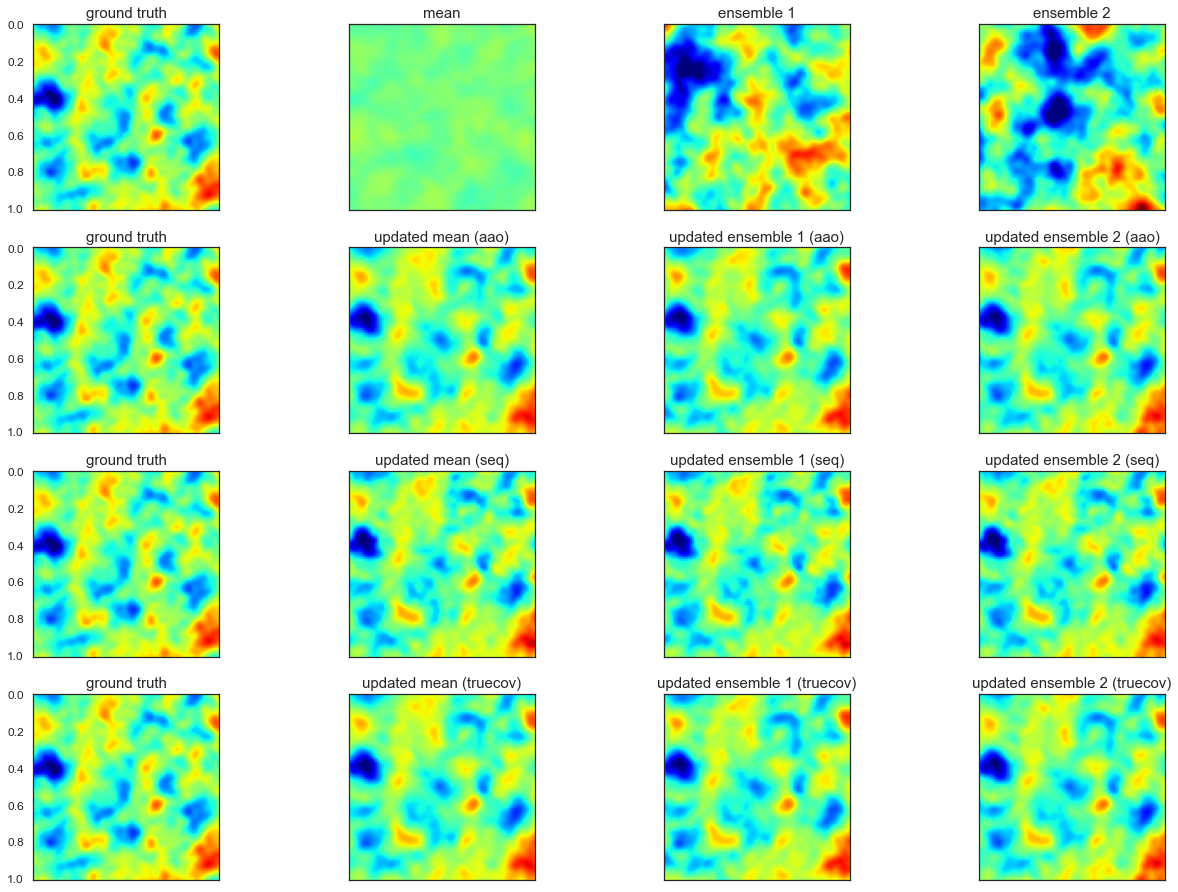

In [94]:
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(4, 4, figsize=(55*cm, 40*cm))

# Prior
grid.plot_vals(ground_truth, axs[0, 0], vmin=-3, vmax=3)
axs[0, 0].title.set_text('ground truth')
axs[0, 0].set_xticks([])

grid.plot_vals(mean, axs[0, 1], vmin=-3, vmax=3)
axs[0, 1].title.set_text('mean')
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

grid.plot_vals(ensemble[0, :], axs[0, 2], vmin=-3, vmax=3)
axs[0, 2].title.set_text('ensemble 1')
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

grid.plot_vals(ensemble[1, :], axs[0, 3], vmin=-3, vmax=3)
axs[0, 3].title.set_text('ensemble 2')
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# All at once update.
grid.plot_vals(ground_truth, axs[1, 0], vmin=-3, vmax=3)
axs[1, 0].title.set_text('ground truth')
axs[1, 0].set_xticks([])

grid.plot_vals(mean_updated_aao_loc, axs[1, 1], vmin=-3, vmax=3)
axs[1, 1].title.set_text('updated mean (aao)')
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

grid.plot_vals(ensemble_updated_aao_loc[0, :], axs[1, 2], vmin=-3, vmax=3)
axs[1, 2].title.set_text('updated ensemble 1 (aao)')
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

grid.plot_vals(ensemble_updated_aao_loc[1, :], axs[1, 3], vmin=-3, vmax=3)
axs[1, 3].title.set_text('updated ensemble 2 (aao)')
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])

# Sequential update.
grid.plot_vals(ground_truth, axs[2, 0], vmin=-3, vmax=3)
axs[2, 0].title.set_text('ground truth')
axs[2, 0].set_xticks([])

grid.plot_vals(mean_updated_seq_loc, axs[2, 1], vmin=-3, vmax=3)
axs[2, 1].title.set_text('updated mean (seq)')
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])

grid.plot_vals(ensemble_updated_seq_loc[0, :], axs[2, 2], vmin=-3, vmax=3)
axs[2, 2].title.set_text('updated ensemble 1 (seq)')
axs[2, 2].set_xticks([])
axs[2, 2].set_yticks([])

grid.plot_vals(ensemble_updated_seq_loc[1, :], axs[2, 3], vmin=-3, vmax=3)
axs[2, 3].title.set_text('updated ensemble 2 (seq)')
axs[2, 3].set_xticks([])
axs[2, 3].set_yticks([])

# Truecov update.
grid.plot_vals(ground_truth, axs[3, 0], vmin=-3, vmax=3)
axs[3, 0].title.set_text('ground truth')
axs[3, 0].set_xticks([])

grid.plot_vals(mean_updated_aao_truecov, axs[3, 1], vmin=-3, vmax=3)
axs[3, 1].title.set_text('updated mean (truecov)')
axs[3, 1].set_xticks([])
axs[3, 1].set_yticks([])

grid.plot_vals(ensemble_updated_aao_truecov[0, :], axs[3, 2], vmin=-3, vmax=3)
axs[3, 2].title.set_text('updated ensemble 1 (truecov)')
axs[3, 2].set_xticks([])
axs[3, 2].set_yticks([])

grid.plot_vals(ensemble_updated_aao_truecov[1, :], axs[3, 3], vmin=-3, vmax=3)
axs[3, 3].title.set_text('updated ensemble 2 (truecov)')
axs[3, 3].set_xticks([])
axs[3, 3].set_yticks([])

plt.savefig('test.png', bbox_inches='tight', dpi=200)

/tmp/ipykernel_15557/753562997.py:12: PerformanceWarning: Slicing with an out-of-order index is generating 33 times more chunks
  data_coords = grid.grid_pts[data_inds, :].compute()


0.8084630065417957
1.2835222641711297
1.3152859504746937


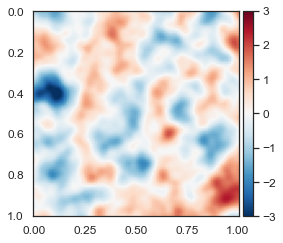

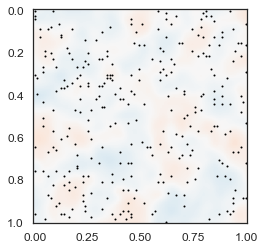

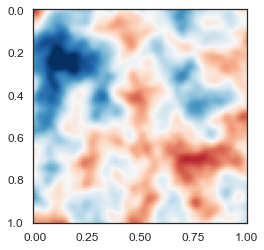

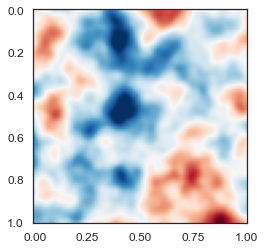

In [95]:
cm = 1/2.54  # centimeters in inches

# Prior
fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
grid.plot_vals(ground_truth, ax, vmin=-3, vmax=3, cmap='RdBu_r', colorbar=True, fig=fig)
plt.savefig(os.path.join(plots_folder, 'ground_truth_synthetic.png'), bbox_inches='tight', dpi=200)

fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
grid.plot_vals(mean, ax, vmin=-3, vmax=3, cmap='RdBu_r', colorbar=False, fig=fig)

# Add location of data point.
data_coords = grid.grid_pts[data_inds, :].compute()
ax.scatter(data_coords[:, 0], data_coords[:, 1], s=1, color='black')

plt.savefig(os.path.join(plots_folder, 'mean_synthetic.png'), bbox_inches='tight', dpi=200)
print(compute_RMSE(mean, ground_truth))

fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
grid.plot_vals(ensemble[0, :], ax, vmin=-3, vmax=3, cmap='RdBu_r', colorbar=False, fig=fig)
plt.savefig(os.path.join(plots_folder, 'ensemble_0_synthetic.png'), bbox_inches='tight', dpi=200)
print(compute_RMSE(ensemble[0, :], ground_truth))

fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
grid.plot_vals(ensemble[1, :], ax, vmin=-3, vmax=3, cmap='RdBu_r', colorbar=False, fig=fig)
plt.savefig(os.path.join(plots_folder, 'ensemble_1_synthetic.png'), bbox_inches='tight', dpi=200)
print(compute_RMSE(ensemble[1, :], ground_truth))

0.32205177575516
0.36184092691906883
0.3461131143670416


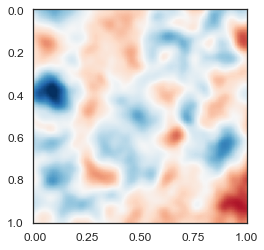

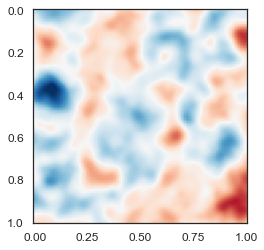

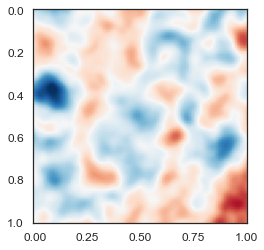

In [96]:
# All at once.
fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
grid.plot_vals(mean_updated_aao_loc, ax, vmin=-3, vmax=3, cmap='RdBu_r', colorbar=False, fig=fig)
plt.savefig(os.path.join(plots_folder, 'mean_updated_aao_loc_synthetic.png'), bbox_inches='tight', dpi=200)
print(compute_RMSE(mean_updated_aao_loc, ground_truth))

fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
grid.plot_vals(ensemble_updated_aao_loc[0, :], ax, vmin=-3, vmax=3, cmap='RdBu_r', colorbar=False, fig=fig)
plt.savefig(os.path.join(plots_folder, 'ensemble_updated_aao_loc_0_synthetic.png'), bbox_inches='tight', dpi=200)
print(compute_RMSE(ensemble_updated_aao_loc[0, :], ground_truth))

fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
grid.plot_vals(ensemble_updated_aao_loc[1, :], ax, vmin=-3, vmax=3, cmap='RdBu_r', colorbar=False, fig=fig)
plt.savefig(os.path.join(plots_folder, 'ensemble_updated_aao_loc_1_synthetic.png'), bbox_inches='tight', dpi=200)
print(compute_RMSE(ensemble_updated_aao_loc[1, :], ground_truth))

0.361786137238143
0.3713881983704567
0.36430857864241306


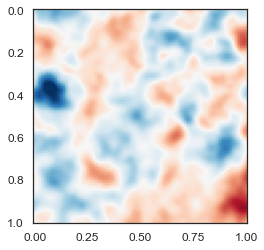

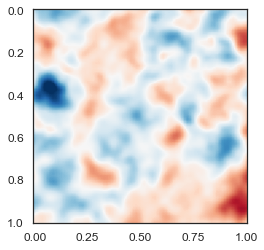

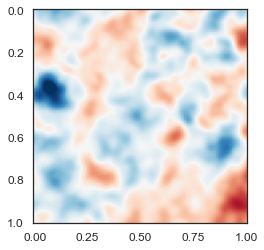

In [97]:
# Sequential.
fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
grid.plot_vals(mean_updated_seq_loc, ax, vmin=-3, vmax=3, cmap='RdBu_r', colorbar=False, fig=fig)
plt.savefig(os.path.join(plots_folder, 'mean_updated_seq_loc_synthetic.png'), bbox_inches='tight', dpi=200)
print(compute_RMSE(mean_updated_seq_loc, ground_truth))

fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
grid.plot_vals(ensemble_updated_seq_loc[0, :], ax, vmin=-3, vmax=3, cmap='RdBu_r', colorbar=False, fig=fig)
plt.savefig(os.path.join(plots_folder, 'ensemble_updated_seq_loc_0_synthetic.png'), bbox_inches='tight', dpi=200)
print(compute_RMSE(ensemble_updated_seq_loc[0, :], ground_truth))

fig, ax = plt.subplots(1, 1, figsize=(10*cm, 10*cm))
grid.plot_vals(ensemble_updated_seq_loc[1, :], ax, vmin=-3, vmax=3, cmap='RdBu_r', colorbar=False, fig=fig)
plt.savefig(os.path.join(plots_folder, 'ensemble_updated_seq_loc_1_synthetic.png'), bbox_inches='tight', dpi=200)
print(compute_RMSE(ensemble_updated_seq_loc[1, :], ground_truth))

## Compute Performance Metrics

In [ ]:
# RMSE
print(np.sqrt(np.mean((mean - ground_truth)**2)))
print(np.sqrt(np.mean((mean_updated_aao_loc - ground_truth)**2)))
print(np.sqrt(np.mean((mean_updated_seq_loc - ground_truth)**2)))
print(np.sqrt(np.mean((mean_updated_aao_truecov - ground_truth)**2)))

In [ ]:
# Energy score.
from diesel.scoring import compute_energy_score

es_prior, _, _ = compute_energy_score(ensemble, ground_truth)
es_aao_loc, _, _ = compute_energy_score(ensemble_updated_aao_loc, ground_truth)
es_seq_loc, _, _ = compute_energy_score(ensemble_updated_seq_loc, ground_truth)
es_aao_truecov, _, _ = compute_energy_score(ensemble_updated_aao_truecov, ground_truth)

print(es_prior)
print(es_aao_loc)
print(es_seq_loc)
print(es_aao_truecov)

## Scoring part.

In [99]:
df_scores = pd.read_pickle(os.path.join(results_folder, "scores.pkl"))

In [100]:
df_scores

,RMSE prior,RMSE aao loc,RMSE seq loc,RMSE aao truecov,ES prior,ES aao loc,ES seq loc,ES aao truecov,RE aao loc,RE seq loc,RE aao truecov
0,0.808463,0.322052,0.361786,0.322052,47.292871,20.629811,25.465592,20.629811,0.916792,0.882883,0.916792
1,1.009478,0.294563,0.369311,0.294563,57.747269,18.516538,25.831516,18.516538,0.959859,0.944829,0.959859
2,0.948551,0.299043,0.373889,0.299043,54.428840,18.910964,26.400244,18.910964,0.944908,0.920918,0.944908
3,0.974558,0.346045,0.467321,0.346045,55.795201,22.201868,33.333961,22.201868,0.931446,0.881872,0.931446
4,1.118603,0.316681,0.398025,0.316681,64.250608,20.187714,28.246310,20.187714,0.951976,0.927703,0.951976
5,0.912493,0.320864,0.406192,0.320864,52.474446,20.623786,29.034397,20.623786,0.933006,0.899056,0.933006
6,1.110927,0.275458,0.384907,0.275458,63.931403,17.080154,27.057931,17.080154,0.960896,0.935950,0.960896
7,1.003200,0.353635,0.441260,0.353635,57.510048,22.510919,30.994650,22.510919,0.932516,0.883506,0.932516
8,0.889598,0.290098,0.368864,0.290098,51.123639,18.399702,26.114041,18.399702,0.938019,0.894256,0.938019
9,1.008493,0.347614,0.419666,0.347614,57.637573,22.259164,29.640865,22.259164,0.939120,0.897172,0.939120


In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
df_melted = pd.melt(df_scores, value_vars=df_scores.columns, var_name="metric", value_name="loss")
df_melted['experiment'] = df_melted['metric']

df_melted.loc[df_melted['experiment'].str.contains("prior"), 'experiment'] = 'Prior'
df_melted.loc[df_melted['experiment'].str.contains("aao loc"), 'experiment'] = 'All-at-once'
df_melted.loc[df_melted['experiment'].str.contains("seq loc"), 'experiment'] = 'Sequential'
df_melted.loc[df_melted['experiment'].str.contains("truecov"), 'experiment'] = 'True covariance'

df_melted.loc[df_melted['metric'].str.contains("RMSE"), 'metric'] = 'RMSE'
df_melted.loc[df_melted['metric'].str.contains("ES"), 'metric'] = 'ES'
df_melted.loc[df_melted['metric'].str.contains("RE"), 'metric'] = 'RE'

In [173]:
# Set plot parameters.
sns.set()                                                                         
sns.set_style("white")                                                            
# plt.rcParams["font.family"] = "Helvetica"                                       
plt.rcParams["font.family"] = ["Arial"]                                           
plot_params = {                                                                   
         'font.size': 25, 'font.style': 'normal',                                  
          'axes.labelsize': 'medium',                                                
          'axes.titlesize':'medium',                                                 
          'legend.fontsize': 'medium',                                               
          'xtick.labelsize': 'medium',                                               
          'ytick.labelsize': 'small',                                               
          }                                                                         
plt.rcParams.update(plot_params)                                                  
plt.rc('xtick', labelsize=22)                                                     
plt.rc('ytick', labelsize=22) 

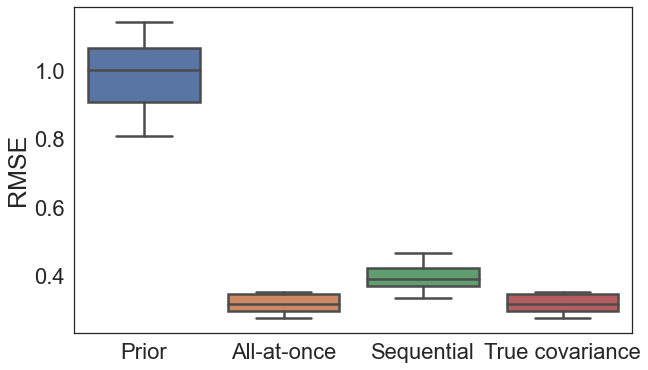

In [136]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted[df_melted['metric'] == 'RMSE'], linewidth=2.5)
ax.set_ylabel('RMSE')
ax.set_xlabel('')
plt.savefig(os.path.join(plots_folder, 'scores_RMSE'), bbox_inches='tight', dpi=200)

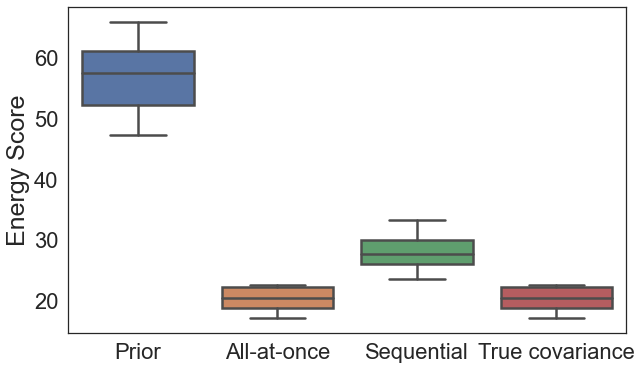

In [137]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted[df_melted['metric'] == 'ES'], linewidth=2.5)
ax.set_ylabel('Energy Score')
ax.set_xlabel('')
plt.savefig(os.path.join(plots_folder, 'scores_ES'), bbox_inches='tight', dpi=200)

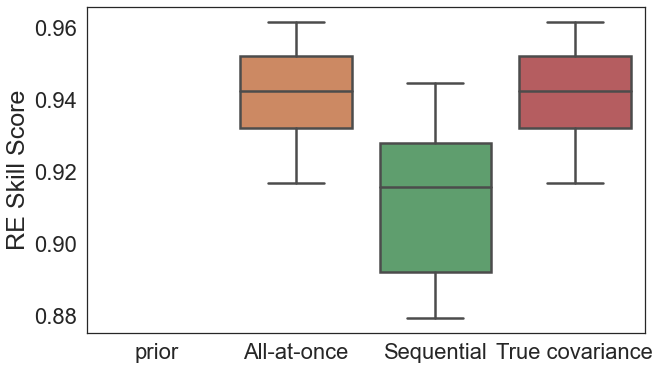

In [138]:
plt.figure(figsize=(10,6))
df_melted_mod = pd.concat([pd.DataFrame({'metric': ['RE'], 'loss': [np.nan], 'experiment': ['prior']}), df_melted], axis=0)

ax = sns.boxplot(x="experiment", y="loss",
                 data=df_melted_mod[df_melted_mod['metric'] == 'RE'], linewidth=2.5)
ax.set_ylabel('RE Skill Score')
ax.set_xlabel('')
plt.savefig(os.path.join(plots_folder, 'scores_RE'), bbox_inches='tight', dpi=200)

## Now plot evolution of scores for different noise levels.

In [181]:
results_evolution_folder = "/home/cedric/PHD/Dev/DIESEL/reporting/toy_example/results_paper/synthetic_different_noise/"
df_evolution = pd.read_pickle(os.path.join(results_evolution_folder, "scores.pkl"))
df_evolution

,repetition,data std,RMSE prior,RMSE aao loc,RMSE seq loc,RMSE aao truecov,ES prior,ES aao loc,ES seq loc,ES aao truecov,RE aao loc,RE seq loc,RE aao truecov
0,0,0.002,1.018189,0.297694,0.370697,0.297694,58.442378,18.653496,25.971108,18.653496,0.963119,0.936319,0.963119
1,0,0.005,1.018189,0.297602,0.364377,0.297602,58.442378,18.623105,25.360189,18.623105,0.963144,0.941390,0.963144
2,0,0.007,1.018189,0.297500,0.360132,0.297500,58.442378,18.599409,24.953357,18.599409,0.963046,0.943697,0.963046
3,0,0.010,1.018189,0.297293,0.354368,0.297293,58.442378,18.559380,24.395722,18.559380,0.963356,0.945406,0.963356
4,0,0.030,1.018189,0.295147,0.333458,0.295147,58.442378,18.227721,22.184431,18.227721,0.963952,0.948245,0.963952
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,5,0.007,0.915396,0.295931,0.383511,0.295931,52.600026,18.883063,27.486080,18.883063,0.937938,0.917980,0.937938
78,5,0.010,0.915396,0.295908,0.381340,0.295908,52.600026,18.852056,27.195982,18.852056,0.937564,0.917861,0.937564
79,5,0.030,0.915396,0.295718,0.367574,0.295718,52.600026,18.629101,25.418101,18.629101,0.938166,0.915895,0.938166
80,5,0.050,0.915396,0.295801,0.358439,0.295801,52.600026,18.422304,24.150846,18.422304,0.937193,0.910895,0.937193


In [182]:
df_evolution['data std'] = 100 * df_evolution['data std']
df_evolution_melted = pd.melt(df_evolution, value_vars=df_scores.columns, var_name="metric", value_name="loss", id_vars=['data std', 'repetition'])
df_evolution_melted['experiment'] = df_evolution_melted['metric']

df_evolution_melted.loc[df_evolution_melted['experiment'].str.contains("prior"), 'experiment'] = 'Prior'
df_evolution_melted.loc[df_evolution_melted['experiment'].str.contains("aao loc"), 'experiment'] = 'All-at-once'
df_evolution_melted.loc[df_evolution_melted['experiment'].str.contains("seq loc"), 'experiment'] = 'Sequential'
df_evolution_melted.loc[df_evolution_melted['experiment'].str.contains("truecov"), 'experiment'] = 'True covariance'

df_evolution_melted.loc[df_evolution_melted['metric'].str.contains("RMSE"), 'metric'] = 'RMSE'
df_evolution_melted.loc[df_evolution_melted['metric'].str.contains("ES"), 'metric'] = 'ES'
df_evolution_melted.loc[df_evolution_melted['metric'].str.contains("RE"), 'metric'] = 'RE'

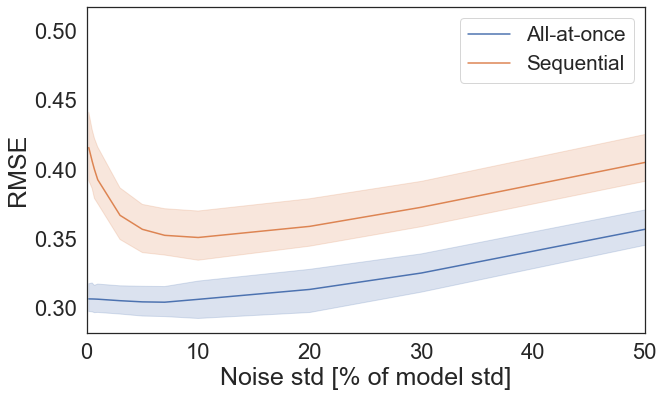

In [189]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=df_evolution_melted.loc[(df_evolution_melted['metric'] == 'RMSE') & (df_evolution_melted['experiment'] != 'True covariance')
                                              & (df_evolution_melted['experiment'] != 'Prior')], x="data std", y="loss", hue='experiment')
ax.set_ylabel('RMSE')
ax.set_xlim([0, 50])
ax.set_xlabel('Noise std [% of model std]')
plt.legend(fontsize='small', title_fontsize='10')
plt.savefig(os.path.join(plots_folder, 'scores_RMSE_evolution'), bbox_inches='tight', dpi=200)

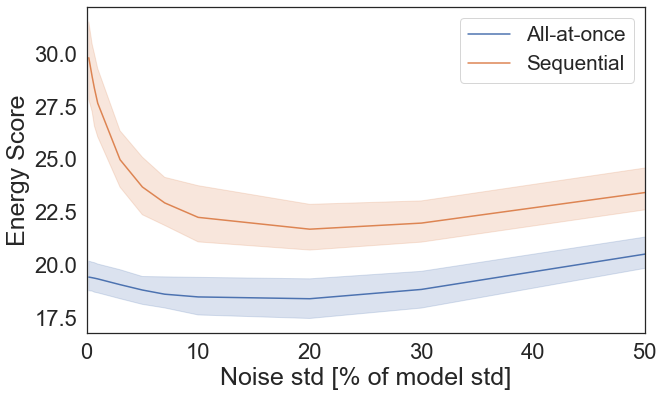

In [191]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=df_evolution_melted.loc[(df_evolution_melted['metric'] == 'ES') & (df_evolution_melted['experiment'] != 'True covariance')
                                              & (df_evolution_melted['experiment'] != 'Prior')], x="data std", y="loss", hue='experiment')
ax.set_ylabel('Energy Score')
ax.set_xlim([0, 50])
ax.set_xlabel('Noise std [% of model std]')
plt.legend(fontsize='small', title_fontsize='10')
plt.savefig(os.path.join(plots_folder, 'scores_ES_evolution'), bbox_inches='tight', dpi=200)

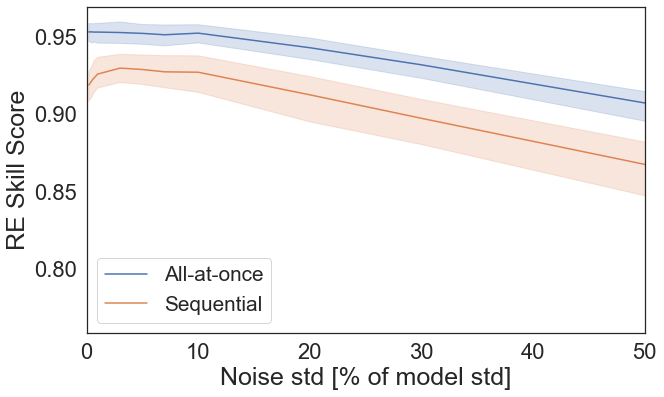

In [190]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=df_evolution_melted.loc[(df_evolution_melted['metric'] == 'RE') & (df_evolution_melted['experiment'] != 'True covariance')], x="data std", y="loss", hue='experiment')
ax.set_ylabel('RE Skill Score')
ax.set_xlim([0, 50])
ax.set_xlabel('Noise std [% of model std]')
plt.legend(fontsize='small', title_fontsize='10')
plt.savefig(os.path.join(plots_folder, 'scores_RE_evolution'), bbox_inches='tight', dpi=200)

In [158]:
df_evolution_melted.loc[(df_evolution_melted['metric'] == 'RMSE') & (df_evolution_melted['experiment'] == 'Prior')]

,data std,repetition,metric,loss,experiment
0,0.002,0,RMSE,1.018189,Prior
1,0.005,0,RMSE,1.018189,Prior
2,0.007,0,RMSE,1.018189,Prior
3,0.010,0,RMSE,1.018189,Prior
4,0.030,0,RMSE,1.018189,Prior
...,...,...,...,...,...
77,0.007,5,RMSE,0.915396,Prior
78,0.010,5,RMSE,0.915396,Prior
79,0.030,5,RMSE,0.915396,Prior
80,0.050,5,RMSE,0.915396,Prior
